This notebook is to document the implementation of drought deciduous only vegetation in FATES.

Issues noted so far include:
1. The biomass doesn't seem to go entirely to zero...
2. The leaf lifespan is hardwired to one year. This means that all the leaves stay on most of the time in always-wet places, which is a problem. 
3. The trigger is voumetric water content, which is an issue because 
    a) this is randomly dependant on soil texture and not a metric of soil stress
    b) it is sensitive to freezing (is that not real)
    c) it tracks the top of the soil, which is too twitchy.
4. We don't have a rainfall trigger ala CLM5. 



In [1]:
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from matplotlib import pyplot as plt
import datetime
import cartopy
import cartopy.crs as ccrs

Then we choose which simulations to use...

In [2]:
runs = ['clm5-fates_DDT','clm5-fates_DDT_LL','clm5-fates_DDT_LL_PT','clm5-fates_DDT_LL_PT_HW_WN']

Then we make an ugly list of variables to ignore (the files being large)

(n.b. does anyone know how to make this inclusive rather than exclusive? 
Reading in >10 years of 4x5 output takes nearly forever)

In [3]:
drop={'ACTUAL_IMMOB','ATM_TOPO','BCDEP','BTRAN','CBALANCE_ERROR_BGC','CBALANCE_ERROR_ED','CBALANCE_ERROR_TOTAL',
      'CWD_STOCK_COL','C_LBLAYER','C_STOMATA','DENIT','DSL','DSTDEP','DSTFLXT','EFLXBUILD','EFLX_DYNBAL',
      'EFLX_GRND_LAKE','EFLX_LH_TOT','EFLX_LH_TOT_R','EFLXBUILD','EFLX_DYNBAL','EFLX_GRND_LAKE','EFLX_LH_TOT',
      'EFLX_LH_TOT_R','ERRH2O','ERRH2OSNO','ERRSEB','ERRSOI','FCEV','FCOV','FCTR','FFIX_TO_SMINN','FGEV','FGR',
      'FGR12','FH2OSFC','FIRA','FIRA_R','FIRE','FSA','FSAT','FSDS','FSDSND','FSDSNDLN','FSDSNI','FSDSVD','FSDSVDLN',
      'FSDSVI','FSDSVILN','FSH','FSH_PRECIP_CONVERSION','FSH_G','FSH_R','FSH_RUNOFF_ICE_TO_LIQ','FSH_TO_COUPLER',
      'FSH_V','FSM','FSNO','FSNO_EFF','FSR','FSRND','FSRNDLN','FSRNI','FSRVD','FSRVDLN','FSRVI','GROSS_NMIN','H2OCAN',
      'H2OSNO_TOP','HEAT_CONTENT1','HEAT_FROM_AC','HIA','HIA_R','HIA_U','HUMIDEX','HUMIDEX_R','HUMIDEX_U',
      'ICE_CONTENT1','LAKEICEFRAC_SURF','LAKEICETHICK','LIQUID_CONTENT1','LITR1N','LITR1N_vr','LITR2N','LITR2N_vr',
      'LITR3N','LITR3N_vr','NDEP_TO_SMINN','NET_NMIN','O_SCALAR','PARVEGLN','PBOT','PCT_GLC_MEC','POTENTIAL_IMMOB',
      'QCHARGE','QDRAI','QDRAI_PERCH','QDRAI_XS','QDRIP','QFLOOD','QFLOOD','QFLX_DEW_GRND','QFLX_DEW_SNOW',
      'QFLX_EVAP_TOT','QFLX_ICE_DYNBAL','QFLX_LIQ_DYNBAL','QFLX_SNOW_DRAIN','QFLX_SNOW_DRAIN_ICE','QFLX_SUB_SNOW',
      'QH2OSFC','QICE','QICE_FRZ','QICE_MELT','QINFL','QINTR','QIRRIG','QOVER','QRGWL','QRUNOFF','QRUNOFF_ICE',
      'QRUNOFF_TO_COUPLER','QSNOCPLIQ','QSNOFRZ','QSNOFRZ_ICE','QSNOMELT','QSNOMELT_ICE','QSNO_TEMPUNLOAD',
      'QSNO_WINDUNLOAD','QSNWCPICE', 'QSOIL_ICE','SABG_PEN','SABV','SMINN','SMINN_LEACHED','SMINN_TO_PLANT',
      'SNOBCMCL','SNOBCMSL','SNOCAN','SNODSTMCL','SNODSTMSL','SNOFSRND','SNOFSRND','SNOFSRVD','SNOFSRVI',
      'SNOINTABS','SNOOCMCL','SNOOCMSL','SNOTXMASS','SNOUNLOAD','SNOW_PERSISTENCE','SNOW_SINKS','SNOW_SOURCES',
      'SOIL1N','SOIL1N_vr','SOIL2N','SOIL2N_vr','SOIL3N','SOIL3N_vr','SOILC_HR','SOILICE','SOILLIQ','SOILRESIS',
      'SOILWATER_10CM','SOM_C_LEACHED','SUPPLEMENT_TO_SMINN','SWBGT','SWBGT_U','TAUX','TAUY','TKE1','TLAKE',
      'TREFMNAV','TREFMXAV','TSOI_ICE','T_SCALAR','U10','U10_DUST','URBAN_AC','URBAN_HEAT','VOLR','VOLRMCH',
      'WASTEHEAT','WBT','WBT_R','WBT_U','W_SCALAR','ZBOT','ZWT','ZWT_PERCH'}

Read data from the archive: (but only the first couple of years for the sake of the aforementioned slowness)

In [24]:
run = runs[0]
scratch = '/glade/scratch/rfisher/'
arc = scratch + 'archive/' + run + '/lnd/hist/'
#arc = scratch + run + '/run/'
f1=(arc +run+'.clm2.h0.2001-01-01-00000.nc')
f2=(arc +run+'.clm2.h0.2002-01-01-00000.nc')
f3=(arc +run+'.clm2.h0.2003-01-01-00000.nc')
f4=(arc +run+'.clm2.h0.2004-01-01-00000.nc')
f5=(arc +run+'.clm2.h0.2005-01-01-00000.nc')
ds0 = xr.open_mfdataset([f1], drop_variables=drop, decode_times=False)

In [31]:
run = runs[1]
scratch = '/glade/scratch/rfisher/'
arc = scratch + 'archive/' + run + '/lnd/hist/'
arc = scratch + run + '/run/'
f1=(arc +run+'.clm2.h0.2001-01-01-00000.nc')
f2=(arc +run+'.clm2.h0.2002-01-01-00000.nc')
f3=(arc +run+'.clm2.h0.2003-01-01-00000.nc')
f4=(arc +run+'.clm2.h0.2004-01-01-00000.nc')
f5=(arc +run+'.clm2.h0.2005-01-01-00000.nc')
print(f1)
ds1 = xr.open_mfdataset([f1], drop_variables=drop, decode_times=False)

/glade/scratch/rfisher/clm5-fates_DDT_LL/run/clm5-fates_DDT_LL.clm2.h0.2001-01-01-00000.nc


In [29]:
run = runs[2]
scratch = '/glade/scratch/rfisher/'
arc = scratch + 'archive/' + run + '/lnd/hist/'
#arc = scratch + run + '/run/'
f1=(arc +run+'.clm2.h0.2001-01-01-00000.nc')
f2=(arc +run+'.clm2.h0.2002-01-01-00000.nc')
f3=(arc +run+'.clm2.h0.2003-01-01-00000.nc')
f4=(arc +run+'.clm2.h0.2004-01-01-00000.nc')
f5=(arc +run+'.clm2.h0.2005-01-01-00000.nc')
print(f2)
ds2 = xr.open_mfdataset([f1], drop_variables=drop, decode_times=False)

/glade/scratch/rfisher/archive/clm5-fates_DDT_LL_PT/lnd/hist/clm5-fates_DDT_LL_PT.clm2.h0.2002-01-01-00000.nc


Then we plot a timeseries of the LAI of all global points

Text(0.5, 1, 'LL=6mo')

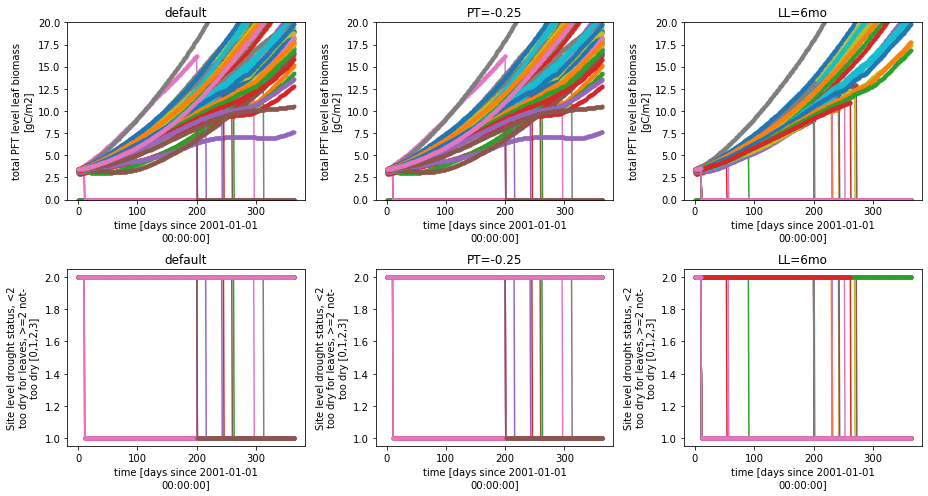

In [32]:
plt.rcParams['figure.figsize'] = [13, 7]
fig,([ax0, ax1,ax2], [ax3,ax4, ax5]) = plt.subplots(ncols=3, nrows=2)
lats=range(19,22)
lons=range(1, 72)
ymx=20

for l in lats:
   ds0.PFTleafbiomass.isel(lat=l, lon=lons, fates_levpft=0).plot.line(ax=ax0,x='time',add_legend=False, marker='.',  ylim=(0,ymx))   
   ds1.PFTleafbiomass.isel(lat=l, lon=lons, fates_levpft=0).plot.line(ax=ax1,x='time',add_legend=False, marker='.', ylim=(0,ymx))
   ds2.PFTleafbiomass.isel(lat=l, lon=lons, fates_levpft=0).plot.line(ax=ax2,x='time',add_legend=False, marker='.',  ylim=(0,ymx))
   ds0.SITE_DROUGHT_STATUS.isel(lat=l, lon=lons).plot.line(ax=ax3,x='time',add_legend=False, marker='.')
   ds1.SITE_DROUGHT_STATUS.isel(lat=l, lon=lons).plot.line(ax=ax4,x='time',add_legend=False, marker='.')
   ds2.SITE_DROUGHT_STATUS.isel(lat=l, lon=lons).plot.line(ax=ax5,x='time',add_legend=False, marker='.')
plt.tight_layout()

ax0.set_title('default')
ax1.set_title('PT=-0.25')
ax2.set_title('LL=6mo')
ax3.set_title('default')
ax4.set_title('PT=-0.25')
ax5.set_title('LL=6mo')

<xarray.DataArray 'lat' (lat: 3)>
array([54., 58., 62.], dtype=float32)
Coordinates:
  * lat      (lat) float32 54.0 58.0 62.0
Attributes:
    long_name:  coordinate latitude
    units:      degrees_north


NameError: name 'xmx' is not defined

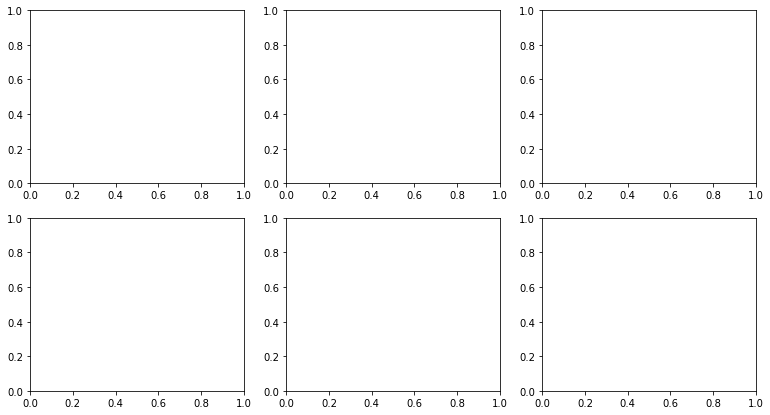

In [8]:
plt.rcParams['figure.figsize'] = [13, 7]
fig,([ax0, ax1,ax2], [ax3,ax4, ax5]) = plt.subplots(ncols=3, nrows=2)
lats=range(36,39)
lons=range(1, 40)
print(ds1.lat[lats])

for l in lats:
   ds0.PFTleafbiomass.isel(lat=l, lon=lons, fates_levpft=0).plot.line(ax=ax0,x='time',add_legend=False, marker='.',  ylim=(0,ymx),  xlim=(0,xmx))   
   ds1.PFTleafbiomass.isel(lat=l, lon=lons, fates_levpft=0).plot.line(ax=ax1,x='time',add_legend=False, marker='.', ylim=(0,ymx),  xlim=(0,xmx))
   ds2.PFTleafbiomass.isel(lat=l, lon=lons, fates_levpft=0).plot.line(ax=ax2,x='time',add_legend=False, marker='.',  ylim=(0,ymx),  xlim=(0,xmx))
   ds0.SITE_DROUGHT_STATUS.isel(lat=l, lon=lons).plot.line(ax=ax3,x='time',add_legend=False, marker='.',  xlim=(0,xmx))
   ds1.SITE_DROUGHT_STATUS.isel(lat=l, lon=lons).plot.line(ax=ax4,x='time',add_legend=False, marker='.',  xlim=(0,xmx))
   ds2.SITE_DROUGHT_STATUS.isel(lat=l, lon=lons).plot.line(ax=ax5,x='time',add_legend=False, marker='.',  xlim=(0,xmx))
plt.tight_layout()

ax0.set_title('default')
ax1.set_title('LL=6mo')
ax2.set_title('PT=-0.25')
ax3.set_title('default')
ax4.set_title('LL=6mo')
ax5.set_title('PT=-0.25')


  From code: meaning of drought statuses...
  
  
  integer, parameter, public :: phen_dstat_timeoff   = 0       ! Leaves off due to time exceedance (drought phenology)                              
  integer, parameter, public :: phen_dstat_moistoff  = 1       ! Leaves off due to moisture avail  (drought phenology)                              
  integer, parameter, public :: phen_dstat_moiston   = 2       ! Leaves on due to moisture avail   (drought phenology)                              
  integer, parameter, public :: phen_dstat_timeon    = 3

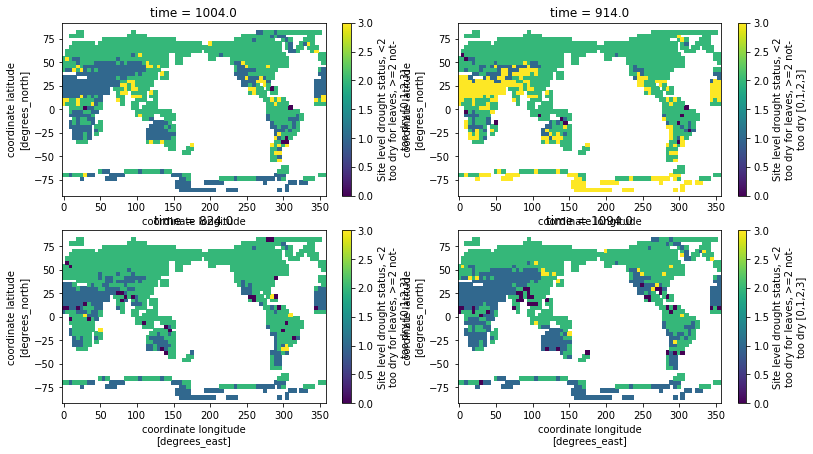

In [11]:
plt.rcParams['figure.figsize'] = [13, 7]
fig,([ax0, ax1],[ax2,ax3]) = plt.subplots(ncols=2, nrows=2)
t=ds2.SITE_COLD_STATUS.sizes['time']-1
ds2.SITE_DROUGHT_STATUS[t-90,:,:].plot(ax=ax0)
ds2.SITE_DROUGHT_STATUS[t-180,:,:].plot(ax=ax1)
ds2.SITE_DROUGHT_STATUS[t-270,:,:].plot(ax=ax2)
ds2.SITE_DROUGHT_STATUS[t,:,:].plot(ax=ax3)


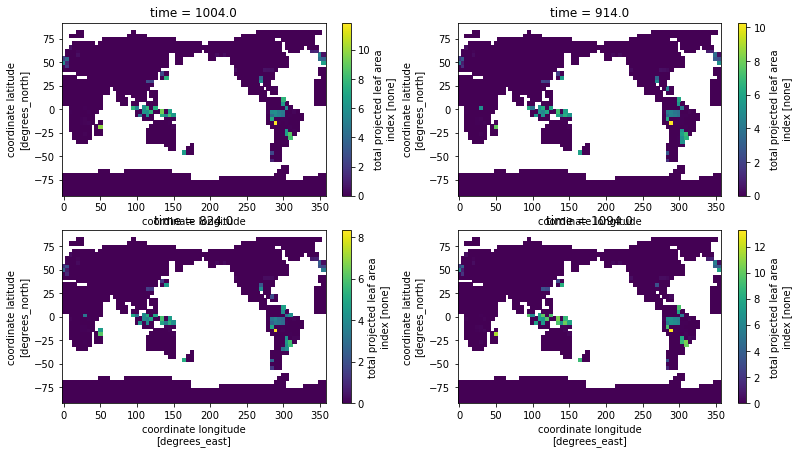

In [12]:
plt.rcParams['figure.figsize'] = [13, 7]
fig,([ax0, ax1],[ax2,ax3]) = plt.subplots(ncols=2, nrows=2)
t=ds2.SITE_COLD_STATUS.sizes['time']-1
ds2.TLAI[t-90,:,:].plot(ax=ax0,clim=[0,2])
ds2.TLAI[t-180,:,:].plot(ax=ax1,clim=[0,2])
ds2.TLAI[t-270,:,:].plot(ax=ax2,clim=[0,2])
ds2.TLAI[t,:,:].plot(ax=ax3,clim=[0,2])

Text(0.5, 1, 'PT=-0.25')

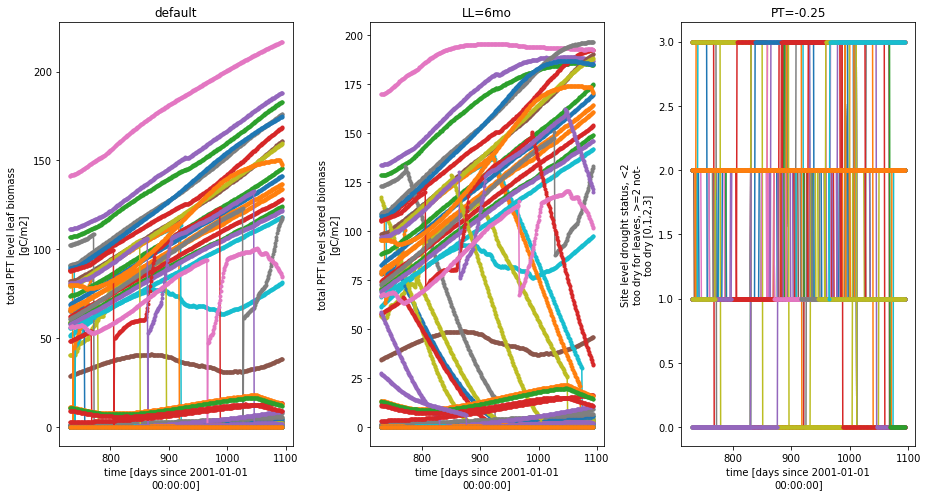

In [13]:
plt.rcParams['figure.figsize'] = [13, 7]
fig,([ax0, ax1,ax2]) = plt.subplots(ncols=3, nrows=1)
lats=range(36)
lons=range(40, 72)
ymx=20

for l in lats:
   ds2.PFTleafbiomass.isel(lat=l, lon=lons, fates_levpft=0).plot.line(ax=ax0,x='time',add_legend=False, marker='.')   
   ds2.PFTstorebiomass.isel(lat=l, lon=lons, fates_levpft=0).plot.line(ax=ax1,x='time',add_legend=False, marker='.')
   ds2.SITE_DROUGHT_STATUS.isel(lat=l, lon=lons).plot.line(ax=ax2,x='time',add_legend=False, marker='.')
plt.tight_layout()



Text(0.5, 1, 'PT=-0.25')

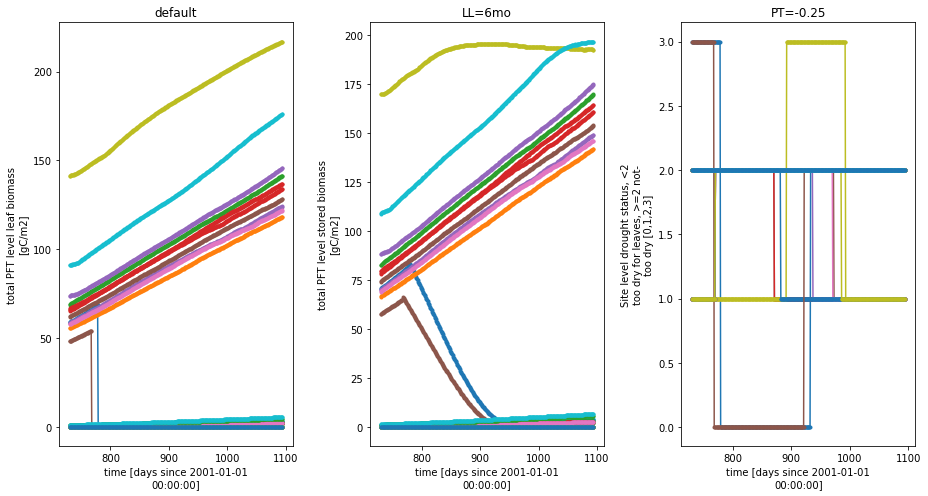

In [14]:
plt.rcParams['figure.figsize'] = [13, 7]
fig,([ax0, ax1,ax2]) = plt.subplots(ncols=3, nrows=1)
lats=range(19,23)
lons=range(40, 72)
ymx=20

for l in lats:
   ds2.PFTleafbiomass.isel(lat=l, lon=lons, fates_levpft=0).plot.line(ax=ax0,x='time',add_legend=False, marker='.')   
   ds2.PFTstorebiomass.isel(lat=l, lon=lons, fates_levpft=0).plot.line(ax=ax1,x='time',add_legend=False, marker='.')
   ds2.SITE_DROUGHT_STATUS.isel(lat=l, lon=lons).plot.line(ax=ax2,x='time',add_legend=False, marker='.')
plt.tight_layout()


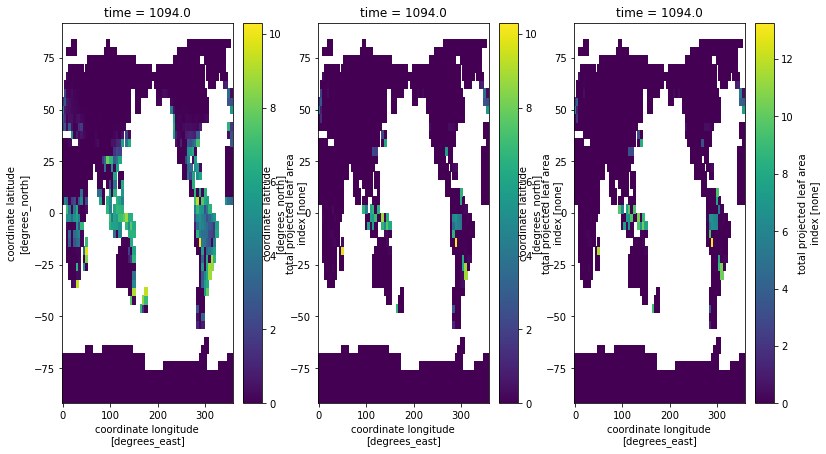

In [23]:
plt.rcParams['figure.figsize'] = [13, 7]
fig,([ax0, ax1,ax2]) = plt.subplots(ncols=3, nrows=1)
t=ds2.SITE_COLD_STATUS.sizes['time']-1
ymx = 5
ds0.TLAI[t,:,:].plot(ax=ax0,clim=(0,ymx))
ds1.TLAI[t,:,:].plot(ax=ax1,clim=(0,ymx))
ds2.TLAI[t,:,:].plot(ax=ax2,clim=(0,ymx))

From this, the tropics are mostly in '0' state, which means they are 'nevercold' and shouldn't have any leaves on, right? (2 is 'not_cold', 1 is 'is_cold')


https://github.com/NGEET/fates/blob/3f6749d471e8766a212dd0a2b0c4c95aacd97f65/biogeochem/EDPhysiologyMod.F90#L741

In [ ]:
plt.rcParams['figure.figsize'] = [10, 8]
fig,([ax0, ax1, ax2]) = plt.subplots(ncols=1, nrows=3)

lats=range(16,19)
lons=range(1, 20)
for l in lats:
   ds2.TLAI.isel(lat=l,  lon=lons).plot.line(x='time',add_legend=False, marker='.',ax=ax0)
plt.title('')
plt.ylim(0,1)

for l in lats:
   ds2.SITE_MEANLIQVOL_DROUGHTPHEN.isel(lat=l,  lon=lons).plot.line(x='time',add_legend=False, marker='.',ax=ax1)
plt.title('')
plt.ylim(0,0.4)

for l in lats:
   ds2.SITE_DROUGHT_STATUS.isel(lat=l,  lon=lons).plot.line(x='time',add_legend=False, marker='o',ax=ax2)
plt.ylim(-0.1,3.1)

In [ ]:
plt.rcParams['figure.figsize'] = [10, 8]
fig,([ax0, ax1, ax2]) = plt.subplots(ncols=1, nrows=3)

lats=range(16,19)
lons=range(1, 20)
for l in lats:
   ds1.GPP.isel(lat=l,  lon=lons).plot.line(x='time',add_legend=False, marker='.',ax=ax0)

for l in lats:
   ds1.PFTleafbiomass.isel(lat=l,  lon=lons, fates_levpft=0).plot.line(x='time',add_legend=False, marker='.',ax=ax1)


for l in lats:
   ds1.PFTstorebiomass.isel(lat=l,  lon=lons, fates_levpft=0).plot.line(x='time',add_legend=False, marker='.',ax=ax2)


Lets double check that all the PFTs are actually cold deciduous

In [ ]:
pftfile='/glade/u/home/rfisher/python_scripts/fates_DDT.nc'
pfts = xr.open_dataset(pftfile)
#print(pfts. fates_phen_season_decid)
#print(pfts. fates_phen_stress_decid)
#print(pfts. fates_phen_evergreen)


...and also that they (there are two identical CLDs) are behaving as expected (is there a fix for the one-pft-crashes on the trunk yet?)

This is where cohortstatus gets defined in recruitment:
https://github.com/NGEET/fates/blob/3f6749d471e8766a212dd0a2b0c4c95aacd97f65/biogeochem/EDPhysiologyMod.F90#L1535

But this seems like it -should- be set to 'leaves_off' if we are in a 'nevercold' regime:
https://github.com/NGEET/fates/blob/3f6749d471e8766a212dd0a2b0c4c95aacd97f65/biogeochem/EDPhysiologyMod.F90#L1359

But what I don't understand is what happens with the new cohorts in PARTEH, particularly with regard to if and how parteh uses the status of the leaves during initialization?
https://github.com/NGEET/fates/blob/3f6749d471e8766a212dd0a2b0c4c95aacd97f65/biogeochem/EDCohortDynamicsMod.F90#L240

Here we look at the 'leaf off' event in more detail. Noting that the majority of places don't go to zero. 

In [ ]:
plt.rcParams['figure.figsize'] = [10, 4]
lats=range(19, 26)
lons=range(1, 72)
for l in lats:
   ds1.PFTleafbiomass.isel(lat=l,  lon=lons, fates_levpft=0).plot.line(x='time',add_legend=False)
plt.title('')
plt.xlim(695,710)

Zooming out a bit more...

In [ ]:
plt.rcParams['figure.figsize'] = [10, 4]
lats=range(19, 26)
lons=range(1, 72)
for l in lats:
   ds1.PFTleafbiomass.isel(lat=l,  lon=lons, fates_levpft=0).plot.line(x='time',add_legend=False)
plt.title('')

Does it look the same for LAI?

In [ ]:
plt.rcParams['figure.figsize'] = [10, 4]
lats=range(19, 26)
lons=range(1, 72)
for l in lats:
   ds8.TLAI.isel(lat=l,  lon=lons).plot.line(x='time',add_legend=False)
plt.title('')
plt.ylim(0,0.6)
plt.xlim(650,1250)

In [ ]:
plt.rcParams['figure.figsize'] = [10, 4]
lats=range(19, 26)
lons=range(1, 72)
for l in lats:
   ds8.NPP.isel(lat=l,  lon=lons).plot.line(x='time',add_legend=False)
plt.title('')
plt.ylim(-0.00002,0.00002)
plt.xlim(650,1250)

GPP is more or less constant

In [ ]:
plt.rcParams['figure.figsize'] = [10, 4]
lats=range(19, 26)
lons=range(1, 72)
for l in lats:
   ds8.GPP.isel(lat=l,  lon=lons).plot.line(x='time',add_legend=False)
plt.title('')
plt.ylim(-0.0000,0.00002)
plt.xlim(650,1250)

but AR canopy is declining

In [ ]:
plt.rcParams['figure.figsize'] = [10, 4]
lats=range(19, 26)
lons=range(1, 72)
for l in lats:
   ds8.AR_CANOPY.isel(lat=l,  lon=lons).plot.line(x='time',add_legend=False)
plt.title('')
plt.ylim(-0.0000,0.00002)
plt.xlim(650,1250)

What is going on with the understorey? Is there an understorey? (yes, but not a lot)

In [ ]:
plt.rcParams['figure.figsize'] = [10, 4]
lats=range(19, 26)
lons=range(1, 72)
for l in lats:
   ds8.AR_UNDERSTORY.isel(lat=l,  lon=lons).plot.line(x='time',add_legend=False)
plt.title('')
plt.ylim(-0.0000,0.00002)
plt.xlim(650,1250)

Most respiration is maintenance...

In [ ]:
plt.rcParams['figure.figsize'] = [10, 4]
fig,([ax0, ax1]) = plt.subplots(ncols=2, nrows=1)
for l in lats:
   ds8.MAINT_RESP.isel(lat=l,  lon=lons).plot.line(ax=ax0,x='time',add_legend=False, xlim=(650,1250),  ylim=(0,0.00002))
   ds8.GROWTH_RESP.isel(lat=l,  lon=lons).plot.line(ax=ax1,x='time',add_legend=False, xlim=(650,1250), ylim=(0,0.00002))
plt.tight_layout()

It is the root biomass that is declining...

MR tissue fluxes are randomly per year not per second...

In [ ]:
plt.rcParams['figure.figsize'] = [10, 4]
spy=3600*23*365/1000
fig,([ax0, ax1]) = plt.subplots(ncols=2, nrows=1)
for l in lats:
   np.divide(ds8.LEAF_MR.isel(lat=l,  lon=lons),spy).plot.line(ax=ax0,x='time',add_legend=False, xlim=(650,1250), ylim=(0,0.00002))
   np.divide(ds8.FROOT_MR.isel(lat=l, lon=lons),spy).plot.line(ax=ax1,x='time',add_legend=False, xlim=(650,1250), ylim=(0,0.00002))
plt.tight_layout()

So from all that I think the sudden uptick makes sense. We have negative NPP, and thus no growth, and then the gradual decline in root N while leaves are off evnetually allows NPP to come back to eing positive again, whereupon the leaf biomass starts to go up, and the LAI/GPP feedback kicks in. Just one last look at stored carbon before we move on

In [ ]:
plt.rcParams['figure.figsize'] = [10, 4]
lats=range(19, 26)
lons=range(1, 72)
for l in lats:
   ds8.PFTstorebiomass.isel(lat=l,  lon=lons, fates_levpft=1).plot.line(x='time',add_legend=False, marker='o')
plt.title('')
#plt.ylim(0,4)
plt.xlim(698,710)